In [ ]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
import seaborn as sb
# from scipy.interpolate import NearestNDInterpolator

from measurements import get_bm_image, get_mesh_from_bm_image,get_tissue_curvature_sparse, export_mesh
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

%load_ext autoreload
%autoreload 2


In [45]:
dirnames = {}

dirnames['Ablation_R1'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R1/'
dirnames['Ablation_R2'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R2/'
dirnames['Ablation_R3'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R1'
dirnames['Ablation_R4'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R2'
dirnames['Ablation_R5'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R1'
dirnames['Ablation_R6'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R2'

dirnames['Ablation_R12'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R1/'
dirnames['Ablation_R13'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R2/'
dirnames['Ablation_R14'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/09-27-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1'
dirnames['Ablation_R16'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/10-04-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1'

dirnames['Ablation_R19'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black unclipped less leaky DOB 06-30-2023/R2/'
dirnames['Ablation_R20'] = '/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black right clipped DOB 06-30-2023/R1'

dx = {'Ablation_R1':0.14599609375,'Ablation_R2':0.14599609375,'Ablation_R3':0.194661458333333,
      'Ablation_R4':0.194661458333333,'Ablation_R5':0.194661458333333,'Ablation_R6':0.194661458333333,
      'Ablation_R12':0.194661458333333,'Ablation_R13':0.194661458333333,
      'Ablation_R14':0.194661458333333,'Ablation_R15':0.194661458333333,'Ablation_R16':0.194661458333333,
      'Ablation_R18':0.2919921875,'Ablation_R19':0.2919921875,'Ablation_R20':0.2919921875}

dz = {'Ablation_R1':1,'Ablation_R2':1,'Ablation_R3':1,'Ablation_R4':1,'Ablation_R5':1,'Ablation_R6':1,
      'Ablation_R12':.7,'Ablation_R13':.7,'Ablation_R14':.7,'Ablation_R15':.7,'Ablation_R16':1,
     'Ablation_R18':0.7,'Ablation_R19':0.7,'Ablation_R20':0.7}

# Grab the first time folder
from glob import glob
from natsort import natsorted

first_time_dir = {}
first_keratinocyte_image = {}
for name,dirname in dirnames.items():
    
    first_timepoint = glob(path.join(dirname,'0. *'))
    if len(first_timepoint) == 0:
        first_timepoint = glob(path.join(dirname,'1. *'))
    
    first_time_dir[name] = first_timepoint[0]
    f = path.join(first_timepoint[0],'G_align.tif')
    if path.exists(f):
        G = io.imread(f)
    else:
        G = io.imread( path.join(first_timepoint[0],'G_reg.tif') )
    first_keratinocyte_image[name] = G

In [21]:
recalculate = True
signs = {'Ablation_R1':-1,'Ablation_R2':-1,'Ablation_R3':+1,'Ablation_R4':-1,'Ablation_R5':+1,'Ablation_R6':+1,
    'Ablation_R12':+1,'Ablation_R13':+1,'Ablation_R14':+1,'Ablation_R15':+1,'Ablation_R16':+1,
     'Ablation_R18':+1,'Ablation_R19':+1,'Ablation_R20':+1}

height_images = {}
# Load heightmaps if exists if not calculate
for name,dirname in first_time_dir.items():
    print(dirname)
    file = path.join(dirname,'height_image.tif')
    
    if path.exists(file) and not recalculate:
        height_images[name] = io.imread(file)
    else:
        heightmap,height_image = get_bm_image(first_keratinocyte_image[name],
                                              sigmas=[5/dz[name],5/dx[name],5/dx[name]],
                                              gradient_sign=signs[name],
                                              method='maximum', threshold=0.2,z_shift=0)
        io.imsave(path.join(dirname,'height_image.tif'), height_image)
        io.imsave(path.join(dirname,'heightmap.tif'), heightmap)
        height_images[name] = height_image
        

/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R1/0. Pre ablation


/Users/xies/Desktop/Code/mouse_skin_size_control/utils/measurements.py:223: RuntimeWarning: invalid value encountered in cast
  interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R1/0. Pre ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R1/0. Pre ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R2/1. Post ablation


/Users/xies/Desktop/Code/mouse_skin_size_control/utils/measurements.py:223: RuntimeWarning: invalid value encountered in cast
  interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R2/1. Post ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-23-2023 R26CreER Rb-fl no tam ablation/R2/1. Post ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R1/1. Post ablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R1/1. Post ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R1/1. Post ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R2/1. Post ablation


/Users/xies/Desktop/Code/mouse_skin_size_control/utils/measurements.py:223: RuntimeWarning: invalid value encountered in cast
  interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R2/1. Post ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R2/1. Post ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R1/1. Post ablation


/Users/xies/Desktop/Code/mouse_skin_size_control/utils/measurements.py:223: RuntimeWarning: invalid value encountered in cast
  interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R1/1. Post ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R1/1. Post ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R2/1. Post ablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R2/1. Post ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-31-2023 R26CreER Rb-fl no tam ablation 8hr/F1 Black/R2/1. Post ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R1/0. Pre ablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R1/0. Pre ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R1/0. Pre ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R2/0. Pre ablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R2/0. Pre ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/08-23-2023 R26CreER Rb-fl no tam ablation 16h/M5 White DOB 4-25-2023/R2/0. Pre ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/09-27-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1/0. Preablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/09-27-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1/0. Preablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/09-27-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1/0. Preablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/09-27-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R2/0. Preablation


/Users/xies/Desktop/Code/mouse_skin_size_control/utils/measurements.py:223: RuntimeWarning: invalid value encountered in cast
  interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/09-27-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R2/0. Preablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/09-27-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R2/0. Preablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/10-04-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1/0. Pre ablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/10-04-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1/0. Pre ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M5 white R26 RBfl DOB 04-25-2023/10-04-2023 R26CreER Rb-fl no tam ablation M5/M5 white DOB 4-25-23/R1/0. Pre ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black unclipped less leaky DOB 06-30-2023/R1/0. Pre ablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black unclipped less leaky DOB 06-30-2023/R1/0. Pre ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black unclipped less leaky DOB 06-30-2023/R1/0. Pre ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black unclipped less leaky DOB 06-30-2023/R2/0. Pre ablation


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black unclipped less leaky DOB 06-30-2023/R2/0. Pre ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black unclipped less leaky DOB 06-30-2023/R2/0. Pre ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black right clipped DOB 06-30-2023/R1/0. Pre ablation


/Users/xies/Desktop/Code/mouse_skin_size_control/utils/measurements.py:223: RuntimeWarning: invalid value encountered in cast
  interpolate.griddata(np.array([Y,X]).T,Z,(grid_y,grid_x), method='linear')).astype(int).T
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black right clipped DOB 06-30-2023/R1/0. Pre ablation/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/M1 M2 K14 Rbfl DOB 06-01-2023/01-13-2024 Ablation K14Cre H2B FUCCI/Black right clipped DOB 06-30-2023/R1/0. Pre ablation/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


In [46]:
from measurements import get_tissue_curvature_over_grid, get_tissue_curvature_sparse
from trimesh import Trimesh

recalculate = True

meshes = {}
mean_curve = {}
gaussian_curve = {}
for name,dirname in first_time_dir.items():

    if path.exists(path.join(dirname,'mesh.npz')) and not recalculate:
        vertices = np.load(path.join(dirname,'mesh.npz'))['vertices']
        faces = np.load(path.join(dirname,'mesh.npz'))['faces']
        mesh = Trimesh(vertices,faces)
    else:
        # Trim first to avoid artefacts
        im = height_images[name][:,100:924,100:924]
        mesh = get_mesh_from_bm_image(im,
                                      spacing=[dz[name],dx[name],dx[name]],decimation_factor=120)
        meshes[name] = mesh
        export_mesh(mesh,path.join(dirname,'mesh.npz'))

    if path.exists(path.join(dirname,'mean_curvature.npz')) and not recalculate:
        mean_curve[name] = np.load(path.join(dirname,'mean_curvature.npz'))['mean_curve']
        gaussian_curve[name] = np.load(path.join(dirname,'gaussian_curvature.npz'))['gaussian_curve']
    else:
        mean_curve[name],gaussian_curve[name] = get_tissue_curvature_over_grid(
            mesh,image_shape=height_images[name].shape,
            spacing=[dz[name],dx[name],dx[name]])
        
        np.savez(path.join(dirname,'mean_curvature.npz'),mean_curve=mean_curve[name])
        np.savez(path.join(dirname,'gaussian_curvature.npz'),gaussian_curve=gaussian_curve[name])

In [47]:
first_time_dir['Ablation_R4']

'/Users/xies/OneDrive - Stanford/Skin/Two photon/NMS/Ablation time courses/F1 black R26 Rbfl DOB 12-27-2022/07-26-2023 R25CreER Rb-fl no tam ablation 12h/Black female/R2/1. Post ablation'

In [48]:
pl = pv.Plotter()
pl.add_mesh(meshes['Ablation_R4'])
pl.show()

Widget(value='<iframe src="http://localhost:49393/index.html?ui=P_0x39e2186e0_7&reconnect=auto" class="pyvista…

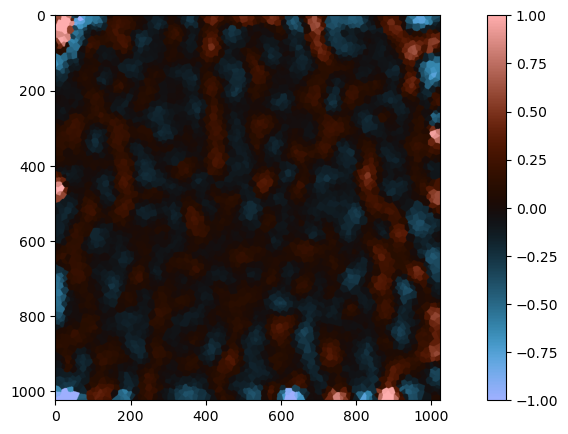

In [49]:
mouse = 'Ablation_R20'

plt.rcParams['figure.figsize'] = [12, 5]
plt.imshow(mean_curve[mouse],vmin=-1,vmax=1,cmap='berlin')
plt.colorbar()

## Load centroids and growth rates

In [50]:
df = []

for name,dirname in dirnames.items():
    fcsv = glob(path.join(dirname,'manual_tracking/Ablation_R*_Nonablation_dataframe.csv'))
    fpickle = glob(path.join(dirname,'manual_tracking',f'Ablation_R*_Nonablation_dense.pkl'))
    if len(fcsv) == 1:
        _df = pd.read_csv(fcsv[0],index_col=0).set_index('CellID',drop=True)
        _tracks = pd.read_pickle(fpickle[0])
        initial = pd.DataFrame({t.iloc[0]['CellID']:t.iloc[0][['X','Y','Z']] for t in _tracks}).T
        _df = pd.merge(_df,initial,left_index=True,right_index=True)
        _df['Region'] = name
        df.append(_df.reset_index())
    else:
        print(name)
        error
    fcsv = glob(path.join(dirname,'manual_tracking/Ablation_R*_Ablation_dataframe.csv'))
    fpickle = glob(path.join(dirname,'manual_tracking',f'Ablation_R*_Nonablation_dense.pkl'))
    if len(fcsv) == 1:
        _df = pd.read_csv(fcsv[0],index_col=0).set_index('CellID',drop=True)
        _tracks = pd.read_pickle(fpickle[0])
        initial = pd.DataFrame({t.iloc[0]['CellID']:t.iloc[0][['X','Y','Z']] for t in _tracks}).T
        _df = pd.merge(_df,initial,left_index=True,right_index=True)
        _df['Region'] = name
        df.append(_df.reset_index())
    else:
        error

df = pd.concat(df,ignore_index=True)

In [51]:
# Look up the local tissue curvature
# mean_curve
df['Mean curvature'] = np.nan
for idx,cell in df.iterrows():

    name = cell['Region']
    curv = mean_curve[name]
    Z,Y,X = cell[['Z','Y','X']].round().astype(int)
    df.loc[idx,'Mean curvature'] = curv[Y,X]
    

array(['WT_F1', 'WT_M5', 'WT_Mnonclip', 'WT_Mclip'], dtype=object)

(-0.02, 0.04)

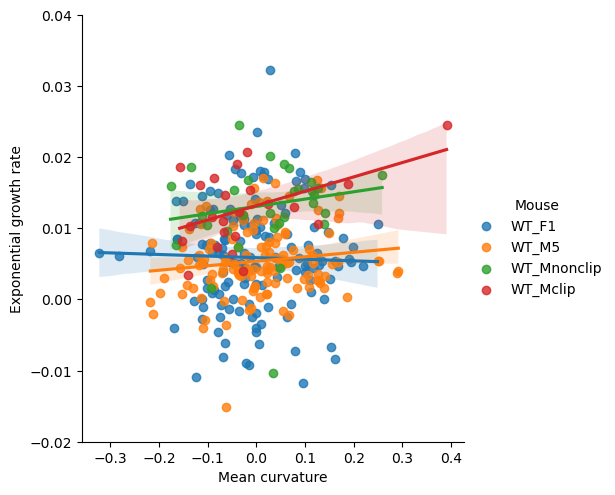

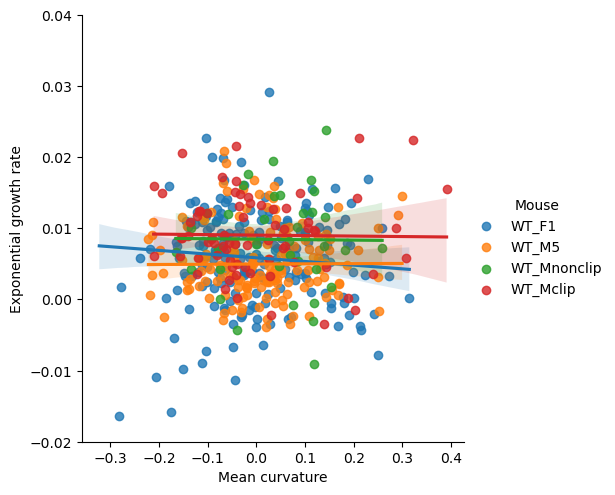

In [54]:
from basicUtils import plot_bin_means
new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}

ablation = df[df['Mode'] == 'Ablation']
nonablation = df[df['Mode'] == 'Nonablation']

sb.lmplot(ablation,x='Mean curvature',y='Exponential growth rate',hue='Mouse',robust=True)
plt.ylim([-0.02,.04])
sb.lmplot(nonablation,x='Mean curvature',y='Exponential growth rate',hue='Mouse',robust=True)
plt.ylim([-0.02,.04])

(-0.02, 0.04)

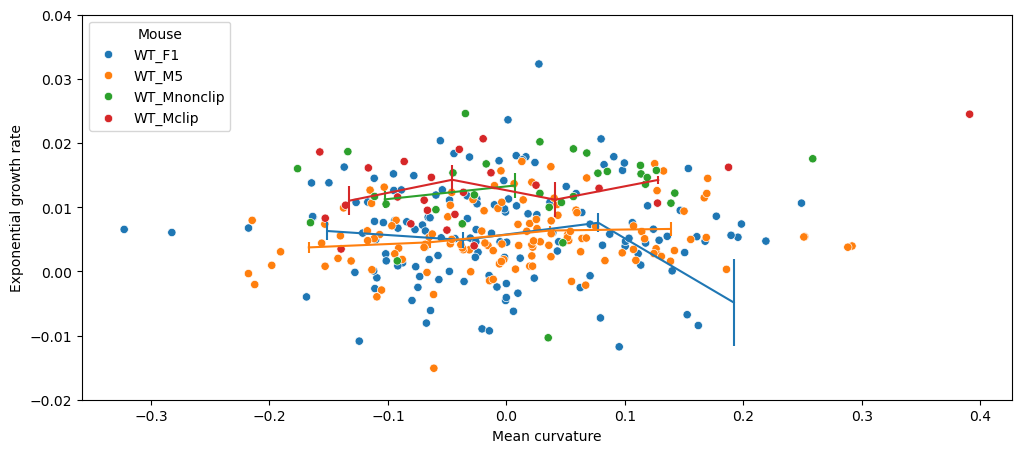

In [61]:
sb.scatterplot(ablation,x='Mean curvature',y='Exponential growth rate',hue='Mouse')
for mouse_name,mouse in ablation.groupby('Mouse'):
    plot_bin_means(mouse['Mean curvature'],mouse['Exponential growth rate'],bin_edges=6,minimum_n=5,
                  mean='mean')
plt.ylim([-0.02,.04])

# sb.catplot(df,x='Mouse',hue='Mode',y='Exponential growth rate',kind='box')
# fig.savefig('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Ablation summary/GR_v_curvature.svg')

In [63]:
df.groupby(['Mouse','Mode']).count()

CellID  um_per_px  um_per_slice  Region  Genotype  \
Mouse       Mode                                                             
WT_F1       Ablation          0        206           206     206       206   
            Nonablation     277        277           277     277       277   
WT_M5       Ablation          0        176           176     176       176   
            Nonablation     196        196           196     196       196   
WT_Mclip    Ablation          0         68            68      68        68   
            Nonablation      79         79            79      79        79   
WT_Mnonclip Ablation          0         85            85      85        85   
            Nonablation      90         90            90      90        90   

                         Pair  Dirname  Birth frame  S phase frame  \
Mouse       Mode                                                     
WT_F1       Ablation        0      206           47             47   
            Nonablation     0      277           83             68   
WT_M5       Ablation        0      176           46             49   
            Nonablation     0      196           44             66   
WT_Mclip    Ablation        0       68            5             22   
            Nonablation     0       79            0             44   
WT_Mnonclip Ablation        0       85           28             31   
            Nonablation     0       90           43             27   

                         Division frame  ...  Total growth normal interp  \
Mouse       Mode                         ...                               
WT_F1       Ablation                 14  ...                           0   
            Nonablation              17  ...                           0   
WT_M5       Ablation                 23  ...                           1   
            Nonablation              27  ...                           0   
WT_Mclip    Ablation                  1  ...                           0   
            Nonablation               0  ...                           0   
WT_Mnonclip Ablation                 10  ...                           0   
            Nonablation              18  ...                           0   

                         S entry size  Log birth size  Fold grown  SG2 growth  \
Mouse       Mode                                                                
WT_F1       Ablation                7              43           0           0   
            Nonablation             3              52           0           0   
WT_M5       Ablation                0              44           1           0   
            Nonablation             0              38           0           0   
WT_Mclip    Ablation                0               3           0           0   
            Nonablation             0               0           0           0   
WT_Mnonclip Ablation                3              28           0           0   
            Nonablation             2              42           0           0   

                           X    Y    Z  index  Mean curvature  
Mouse       Mode                                               
WT_F1       Ablation     206  206  206    206             206  
            Nonablation  277  277  277      0             277  
WT_M5       Ablation     176  176  176    176             176  
            Nonablation  196  196  196      0             196  
WT_Mclip    Ablation      68   68   68     68              68  
            Nonablation   79   79   79      0              79  
WT_Mnonclip Ablation      85   85   85     85              85  
            Nonablation   90   90   90      0              90  

[8 rows x 45 columns]